# Проект по выявлению токсичных комментариев


В рамках проекта заказчик предоставил массив данных с комментариями к товарам на своей платформе.

Перед нами поставлена задача по построению модели для предсказания тональности комментария. Значение метрики качества модели F1 должно быть не менее 0.75. На основе предсказания предполагается отправлять предположительно токсичные комментарии на модерацию.

## Подготовка данных

### Установка библиотек

In [1]:
#!pip install -q lightgbm

### Импорт библиотек

In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import warnings
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from numpy import mean
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)
from sklearn.metrics import (
    precision_score,
    recall_score
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    GridSearchCV
)
from sklearn.pipeline import (
    Pipeline,
    make_pipeline
)
from sklearn.utils import shuffle
from tqdm.notebook import tqdm

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tempe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tempe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tempe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tempe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Сохраняем данные в переменную


In [4]:
pth1 = 'C:\\Dataset\\toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'
# пути к фрейму

if os.path.exists(pth1):
    coments = pd.read_csv(pth1)
elif os.path.exists(pth2):
    coments = pd.read_csv(pth2)
else:
    print("Проверьте путь к датасету")

pd.set_option('display.max_columns', 50)

backup = coments.copy(deep=True)
# На всякий случай пусть будет копия

### Проводим первичное исследование на предмет наличия пропусков

In [5]:
coments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
coments.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


#### Удалим знаки припинания, символы и приведем к нижнему регистру

In [7]:
# Первоисточник кода:
# https://rukovodstvo.net/posts/id_939/

def preprocess_text(sen): # функция очищает текст и приводит к нижнему регистру
    # Удаление html тэгов  
    cleared_text = re.sub(r'<[^>]+>', '', sen)

    # Удаление знаков припенания и цифр 
    cleared_text = re.sub('[.!#$%&*+"/=?^_`{|}~-]', ' ', cleared_text) 
 
    # Удаление одиночных символов 
    cleared_text = re.sub(r"\s+[a-zA-Z]\s+", ' ', cleared_text) 
 
    # Удаление нескольких пробелов
    cleared_text = re.sub(r'\s+', ' ', cleared_text) 
    
    # Преведение к нижнему регистру
    cleared_text = cleared_text.lower()    
 
    return cleared_text 

In [8]:
%%time
reviews = [] 
sentences = list(coments['text']) 

for sen in sentences: 
    reviews.append(preprocess_text(sen)) 

CPU times: total: 13.8 s
Wall time: 14.5 s


In [9]:
reviews = pd.DataFrame(reviews)
coments['text'] = reviews[0]

In [10]:
display(coments.head(10))

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,d'aww he matches this background colour i'm se...,0
2,2,"hey man, i'm really not trying to edit war it'...",0
3,3,more can't make any real suggestions on impro...,0
4,4,"you, sir, are my hero any chance you remember ...",0
5,5,"congratulations from me as well, use the tool...",0
6,6,cocksucker before you piss around on my work,1
7,7,your vandalism to the matt shirvington article...,0
8,8,sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


#### Проверим баланс классов

In [11]:
coments['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [12]:
coments.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

В данных наблюдается значительный дисбаланс. При этом в рамках задачи нас интересуют именно токсичные комментарии. Поскольку именно они будут направляться на дополнительную модерацию и должны определяться достоверно. Пропусков в данных не имеется.

In [13]:
target_names = ['Отзыв не токсичный, [0]','Отзыв токсичный, [1]'] 
# будем использовать в графиках и при выводе сводных результатов работы моделей

In [14]:
def pie_for_class(df): # построение графика баланса классов
    plt.figure(figsize=(5, 5))

    plt.pie(df.value_counts(normalize=True, sort=False, ascending=True),
        labels=target_names,
        labeldistance=1.05, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' });

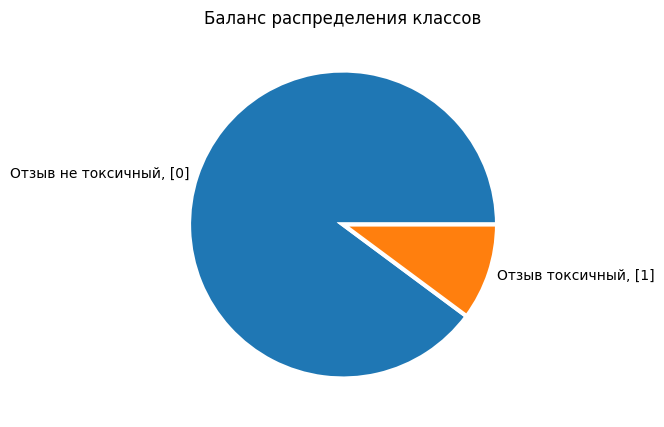

CPU times: total: 234 ms
Wall time: 278 ms


In [15]:
%%time
pie_for_class(coments['toxic'])
plt.title('Баланс распределения классов')
plt.show()

#### Поделим на обучающую, валидационную и тестовую выборки с учетом дисбаланса классов

In [16]:
X = coments['text']
y = coments['toxic']

train_future, y_future, train_target, y_target = train_test_split(
    X,
    y,
    test_size=.2,
    random_state=12345,
    stratify=y
)

valid_future, test_future, valid_target, test_target = train_test_split(
    y_future,
    y_target,
    test_size=.50,
    random_state=12345,
    stratify=y_target
)

In [17]:
print(
    f'Обучающая выборка: {train_future.shape} {train_target.shape}', 
    '\n', f'Валидационная выборка: {valid_future.shape} {valid_target.shape}',
    '\n',
    f'Тестовая выборка: {test_future.shape} {test_target.shape}',
    sep=''
)

Обучающая выборка: (127433,) (127433,)
Валидационная выборка: (15929,) (15929,)
Тестовая выборка: (15930,) (15930,)


In [18]:
def down_up_sample(text, sample, fraction): # функция для усреднения баланса классов
    text_zeros = text[sample == 0]
    text_ones = text[sample == 1]
    sample_zeros = sample[sample == 0]
    sample_ones = sample[sample == 1]

    text_down_up = pd.concat(
        [text_zeros.sample(frac=fraction, random_state=12345)] + [text_ones]
    )
    sample_down_up = pd.concat(
        [sample_zeros.sample(frac=fraction, random_state=12345)] + [sample_ones]
    )
    
    text_down_up_sampled, sample_down_up_sampled = shuffle(
        text_down_up,
        sample_down_up,
        random_state=12345
    )
    
    return text_down_up_sampled, sample_down_up_sampled

In [19]:
train_future, train_target  = down_up_sample(X, y, 0.1)

Изменили баланс классов только на обучающей выборке, поскольку после обучения модели точно придется предсказывать по данным, в которых содержится дисбаланс классов.

In [20]:
print(f'Обучающая выборка: {train_future.shape} {train_target.shape}')

Обучающая выборка: (30497,) (30497,)


In [21]:
train_target.sum() # количество токсичных отзывов составляет чуть больше 50%

16186

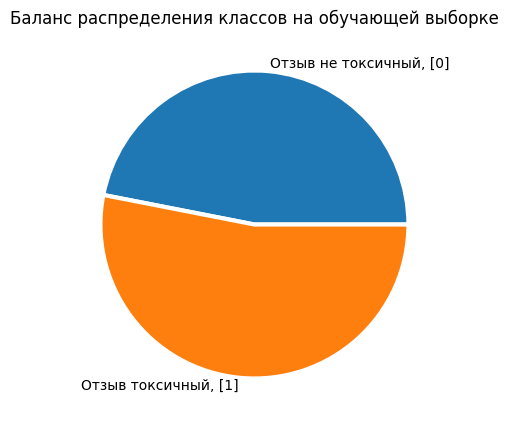

CPU times: total: 156 ms
Wall time: 163 ms


In [22]:
%%time
pie_for_class(train_target)
plt.title('Баланс распределения классов на обучающей выборке')
plt.show()

In [23]:
coments['Unnamed: 0'].max()

159450

In [24]:
coments.shape

(159292, 3)

Unnamed: 0	- странный столбец. Нумерация отличается от размера фрейма. Возможно не предоставлена часть комментариев.

#### Лемматизируем текст

In [25]:
stop_words = set(nltk_stopwords.words('english')) # присваем список стоп слов

In [26]:
lemmatizer = WordNetLemmatizer() # инициализируем лемматизатор

In [27]:
name_frame = [train_future, valid_future, test_future] # фиксируем наименования выборок

In [28]:
def get_wordnet_pos(word): # данная функция позволяет учесть разное употребление слова
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [29]:
%%time
def lemmafunction(text): # непосредственно лематизация текста. Пропускаем стоп слова, чтобы съэкономить время
    k=[]
    for i in nltk.word_tokenize(text): 
        y = lemmatizer.lemmatize(i, get_wordnet_pos(i))
        if y not in stop_words:
            k.append(y)
            
    return ' '.join(k) 

lemma = []

for n in name_frame:
    corpus = list(n)
    for i in tqdm(range(len(corpus))):
    
        lemma.append(lemmafunction(corpus[i]))
    
    n = pd.Series(lemma)

  0%|          | 0/30497 [00:00<?, ?it/s]

  0%|          | 0/15929 [00:00<?, ?it/s]

  0%|          | 0/15930 [00:00<?, ?it/s]

CPU times: total: 1h 14min 2s
Wall time: 1h 16min 12s


#### Добавим значения TF-IDF для слов

In [30]:
count_tf_idf = TfidfVectorizer(
    stop_words=stop_words,
    analyzer='word'
) # инициализируем функцию по подсчету TF-IDF

### Построим модели для предсказания токсичных комментариев

#### Модель логистической регрессии с подбором параметров

In [31]:
def predict_model(model, future, target, target_names): # вычисление предсказания
    prediction_model = model.predict(future)
    f1_model = f1_score(target, prediction_model)
    print(classification_report(target, prediction_model, target_names=target_names))
    print('Метрика F1 качества предсказания модели равна :', f1_model.round(2))
    return prediction_model, f1_model

In [32]:
%%time

clf_lr_pipeline = make_pipeline(
    TfidfVectorizer(
        stop_words=stop_words,
        analyzer='word'
    ), 
    LogisticRegression(
        random_state=12345,
        solver='liblinear',
        class_weight='balanced'
    )
)



parametrs_lr = {
              'C': np.arange(2., 10.2, .3)
              }

new_params_lr = {
    'logisticregression__' + key: parametrs_lr[key] for key in parametrs_lr
}



grid_lr = GridSearchCV(
    clf_lr_pipeline,
    param_grid=new_params_lr,
    cv=5,
    scoring='f1',
    return_train_score=True
)

grid_lr.fit(train_future, train_target)

print(
    'F1 на обучающей выборке: {:.2f}'.format(grid_lr.best_score_)
)

F1 на обучающей выборке: 0.90
CPU times: total: 10min 40s
Wall time: 10min 48s


In [33]:
grid_lr.best_params_

{'logisticregression__C': 6.499999999999997}

In [34]:
prediction_lr_model, f1_lr_model = predict_model(
    grid_lr,
    valid_future,
    valid_target,
    target_names
)

                         precision    recall  f1-score   support

Отзыв не токсичный, [0]       1.00      0.92      0.96     14311
   Отзыв токсичный, [1]       0.59      0.97      0.73      1618

               accuracy                           0.93     15929
              macro avg       0.79      0.95      0.85     15929
           weighted avg       0.96      0.93      0.94     15929

Метрика F1 качества предсказания модели равна : 0.73


In [35]:
def predict_result(name_model, F1): # функция построения таблицы с результатами
    x = [[name_model, F1]]
    y = pd.DataFrame(x, columns=['model', 'F1'])
    return y

In [36]:
frame_1 = predict_result('LogisticRegression', f1_lr_model.round(2))

#### Модель градиентного бустинга LGBM для логистической регрессии 

In [37]:
%%time
#model_LGBM = LGBMClassifier(random_state=12345)

LGBM_pipeline = make_pipeline(
    TfidfVectorizer(
        stop_words=stop_words,
        analyzer='word'
    ), 
    LGBMClassifier(random_state=12345)
)


n_scores = cross_val_score(
    LGBM_pipeline,
    train_future,
    train_target,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

print(
    'Средняя точность на текстовой выборке: %.2f' % (mean(n_scores))
)

LGBM_pipeline.fit(train_future, train_target)


prediction_model_LGBM, f1_model_LGBM = predict_model(
    LGBM_pipeline,
    valid_future,
    valid_target,
    target_names
)

Средняя точность на текстовой выборке: 0.88
                         precision    recall  f1-score   support

Отзыв не токсичный, [0]       0.98      0.94      0.96     14311
   Отзыв токсичный, [1]       0.63      0.86      0.73      1618

               accuracy                           0.93     15929
              macro avg       0.81      0.90      0.85     15929
           weighted avg       0.95      0.93      0.94     15929

Метрика F1 качества предсказания модели равна : 0.73
CPU times: total: 44.4 s
Wall time: 43.7 s


In [38]:
frame_2 = predict_result(
    'LogisticRegression_LGBM', f1_model_LGBM.round(2)
)

#### Модель случайного леса

In [39]:
%%time

parametrs_forest_model = {
    'n_estimators': range (1, 14, 6),
    'max_depth': range (1, 6, 2),
    'min_samples_leaf': range (1, 4, 2),
    'min_samples_split': range (2, 5, 2)
}

forest_pipeline = make_pipeline(
    TfidfVectorizer(
        stop_words=stop_words,
        analyzer='word'
    ), 
    RandomForestClassifier(
        random_state=12345,
        class_weight='balanced'
    )
)

new_params_forest = {
    'randomforestclassifier__' + key: parametrs_forest_model[key]
    for key in parametrs_forest_model
}



grid_forest = GridSearchCV(
    forest_pipeline,
    param_grid=new_params_forest,
    cv=5,
    scoring='f1',
    return_train_score=True
)

grid_forest.fit(train_future, train_target)

print(
    'F1 на обучающей выборке: {:.3f}'.format(grid_forest.best_score_)
)

F1 на обучающей выборке: 0.732
CPU times: total: 12min 11s
Wall time: 12min 17s


In [40]:
prediction_forest_model, f1_forest_model = predict_model(
    grid_forest,
    valid_future,
    valid_target,
    target_names
)

                         precision    recall  f1-score   support

Отзыв не токсичный, [0]       0.96      0.53      0.68     14311
   Отзыв токсичный, [1]       0.17      0.83      0.28      1618

               accuracy                           0.56     15929
              macro avg       0.56      0.68      0.48     15929
           weighted avg       0.88      0.56      0.64     15929

Метрика F1 качества предсказания модели равна : 0.28


In [41]:
frame_3 = predict_result('RandomForestClassifier', f1_forest_model.round(2))

#### Прогноз на основе простого заполнения предсказаний наиболее встречающимся классом для проверки адекватности моделей

In [42]:
warnings.simplefilter('ignore')


dummy_pipeline = make_pipeline(
    TfidfVectorizer(
        stop_words=stop_words,
        analyzer='word'
    ), 
    DummyClassifier(strategy="most_frequent")
)

dummy_pipeline.fit(train_future, train_target)

prediction_dummy_clf, f1_dummy_clf = predict_model(
    dummy_pipeline,
    valid_future,
    valid_target,
    target_names
)

                         precision    recall  f1-score   support

Отзыв не токсичный, [0]       0.00      0.00      0.00     14311
   Отзыв токсичный, [1]       0.10      1.00      0.18      1618

               accuracy                           0.10     15929
              macro avg       0.05      0.50      0.09     15929
           weighted avg       0.01      0.10      0.02     15929

Метрика F1 качества предсказания модели равна : 0.18


In [43]:
frame_4 = predict_result('DummyClassifier', f1_dummy_clf.round(2))

In [44]:
frames = [frame_1, frame_2, frame_3, frame_4]
df_prediction = pd.concat(frames)
display(df_prediction)

,model,F1
0,LogisticRegression,0.73
0,LogisticRegression_LGBM,0.73
0,RandomForestClassifier,0.28
0,DummyClassifier,0.18


Из-за проверки обучения на датасете с отбалансированными классами и проверке на валидационной выборке с несбалансированностью классов модель показала невысокий результат. F1 = 0.18, что значительно хуже лучшего показателя F1 = 0.74.

##### Посмотрим матрицу ошибок и вероятность предсказания токсичных комментариев для лучшей модели.

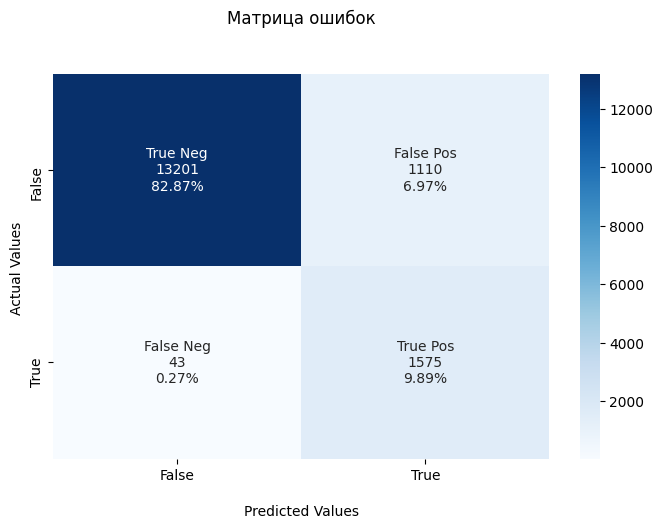

In [45]:
# Первоисточник кода:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

cnf_matrix = confusion_matrix(valid_target, prediction_lr_model)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8, 5))

ax = sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [46]:
probabilities = grid_lr.predict_proba(valid_future)
probabilities_one = probabilities[:, 1]
print("Вероятность положительного класса:",probabilities_one[:5])

Вероятность положительного класса: [0.93225959 0.47736764 0.06023033 0.28545308 0.02778973]


Большой разброс от 0.03 до 0.9. Вероятно, модель можно улушить изменением порога в сторону повышения значения точности. Таким образом мы получит большее количество верных предсказаний токсичных комментариев.

In [47]:
for threshold in np.arange(0.4, 0.9, 0.02):
    predicted_v = probabilities_one > threshold
    precision = precision_score(valid_target,predicted_v)
    recall = recall_score(valid_target,predicted_v) 
    f1 = f1_score(valid_target,predicted_v)
    print(
        "Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
            threshold,
            precision,
            recall,
            f1
        )
    )

Порог = 0.40 | Точность = 0.498, Полнота = 0.990, F1 = 0.663
Порог = 0.42 | Точность = 0.517, Полнота = 0.988, F1 = 0.679
Порог = 0.44 | Точность = 0.533, Полнота = 0.986, F1 = 0.692
Порог = 0.46 | Точность = 0.552, Полнота = 0.983, F1 = 0.707
Порог = 0.48 | Точность = 0.572, Полнота = 0.979, F1 = 0.722
Порог = 0.50 | Точность = 0.587, Полнота = 0.973, F1 = 0.732
Порог = 0.52 | Точность = 0.603, Полнота = 0.971, F1 = 0.744
Порог = 0.54 | Точность = 0.618, Полнота = 0.965, F1 = 0.754
Порог = 0.56 | Точность = 0.634, Полнота = 0.957, F1 = 0.763
Порог = 0.58 | Точность = 0.654, Полнота = 0.952, F1 = 0.776
Порог = 0.60 | Точность = 0.675, Полнота = 0.948, F1 = 0.788
Порог = 0.62 | Точность = 0.696, Полнота = 0.940, F1 = 0.800
Порог = 0.64 | Точность = 0.711, Полнота = 0.928, F1 = 0.805
Порог = 0.66 | Точность = 0.725, Полнота = 0.915, F1 = 0.809
Порог = 0.68 | Точность = 0.741, Полнота = 0.907, F1 = 0.816
Порог = 0.70 | Точность = 0.756, Полнота = 0.895, F1 = 0.819
Порог = 0.72 | Точность 

##### Построим кривую точности-полноты

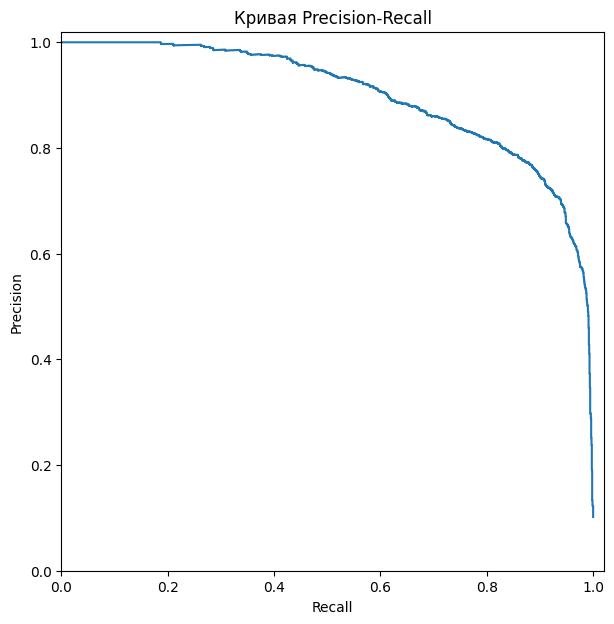

In [48]:
precision, recall, thresholds = precision_recall_curve(
    valid_target,
    probabilities[:, 1]
)
plt.figure(figsize=(7, 7))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.02])
plt.xlim([0.0, 1.02])
plt.title('Кривая Precision-Recall')
plt.show() 

Визуально кажется, что оптимальный порог находится на значении, превышающем 0.72. Проверим.

In [49]:
predicted_rf_threshold = (probabilities_one > .72)*1
print(
    classification_report(
        valid_target,
        predicted_rf_threshold,
        target_names=target_names
    )
)

                         precision    recall  f1-score   support

Отзыв не токсичный, [0]       0.99      0.97      0.98     14311
   Отзыв токсичный, [1]       0.77      0.88      0.82      1618

               accuracy                           0.96     15929
              macro avg       0.88      0.93      0.90     15929
           weighted avg       0.96      0.96      0.96     15929



In [50]:
prediction_lr_model_vt = (grid_lr.predict_proba(valid_future)[:,1] > .72)*1
f1_lr_model_vt = f1_score(valid_target, prediction_lr_model_vt)

print(
    'Валидационный F1 : {:.2f} (порог: 0.72)'.format(f1_lr_model_vt))

Валидационный F1 : 0.82 (порог: 0.72)


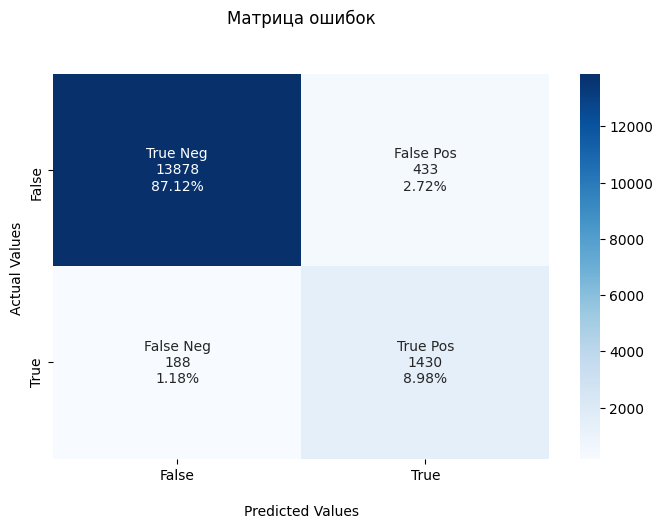

In [51]:
cnf_matrix = confusion_matrix(valid_target, predicted_rf_threshold)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8, 5))

ax = sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

<a id='tag_1'></a>

### Мы в некоторой степени пожертвовали точностью предсказания токсичных комментариев, чтобы в токсичные не попадало большое количество обычных комментариев. 

Количество токсичных комментариев, отнесенных к обычных увеличилось с 3% от общего количества токсичных комментариев, до 11%. Однако удалось снизить количество нейтральных комментариев, отнесенных к токсичным с 40% до 20%.

В первом случае мы выявляем большее количиство токсичных комментариев, во втором обработке подлежит меньшее количество комментариев.

### Проверим лучшую модель на тестовой выборке

In [52]:
prediction_lr_model_t = (grid_lr.predict_proba(test_future)[:,1] > .62)*1
f1_lr_model_t = f1_score(
    test_target,
    prediction_lr_model_t
)

print('Тестовый F1: {:.2f}'.format(f1_lr_model_t))

Тестовый F1: 0.80


#### Рассчитаем значение ROC-AUC и визуализируем его

In [53]:
fpr, tpr, thresholds = roc_curve(
    test_target,
    prediction_lr_model_t
)
auc_roc = roc_auc_score(
    test_target,
    prediction_lr_model_t
)
print('ROC-AUC: {:.2f}'.format(auc_roc))

ROC-AUC: 0.95


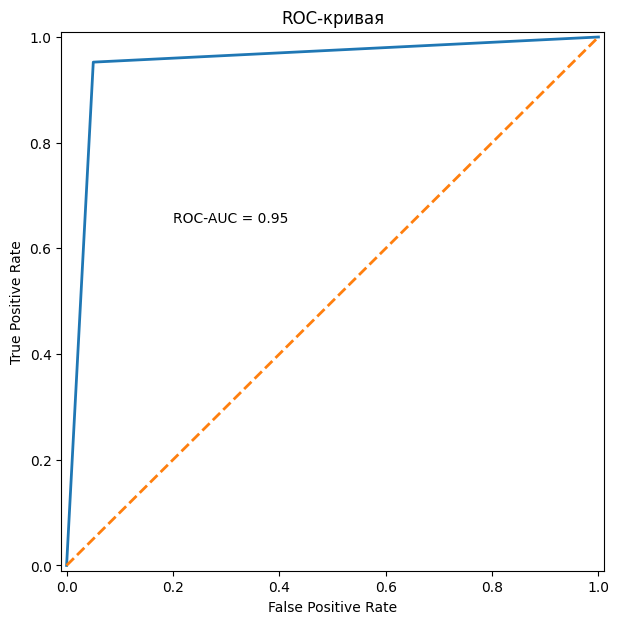

In [54]:
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr,linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.text(0.2,0.65,'ROC-AUC = {:.2f}'.format(auc_roc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Исходя из площади под кривой можно сделать вывод, что модель работает хорошо.

**Заключение:**

В рамках проекта обучена модель логистической регрессии с целевым значение заданной метрики:
- Обучающая выборка **F1 = 0.9**
- Валидационная выборка **F1 = 0.82**
- Тестовая выборка **F1 = 0.8**

При этом **можно [добиться](#tag_1) более точных предсказаний** токсичных комментариев. 

На валидационной выборке этот показатель можно поднять с 89% до 96%. 

Однако это приведет к менее точному предсказанию нейтральных комментариев и увеличению количества комментариев, представляемому на модерацию. 

Как следствие целевая метрика F1 снизится до 0.74.